# Question 1

D'après la question 10 de l'exo 2.5.6 on a :

$
\hat{Z}(t) = \int_{0}^{t} h(s) \left(1 - \hat{Z}(s) \right) ds -
\int_{0}^{t} (b - a) \hat{Z}(s) \left(1 - \hat{Z}(s) \right) ds +
\sum_{T_k \leq t} \frac{(b - a) \hat{Z}(T_k^-) \left(1 - \hat{Z}(T_k^-) \right)}{a + (b - a) \hat{Z}(T_k^-)}
$

Entre les sauts de N, la dynamique est donc donnée par :    
$
\hat{Z}(t)  - \hat{Z}(T_{n-1}) = \int_{0}^{t} (h(s)-(b-a)\hat{Z}(s))(1-\hat{Z}(s))ds
$

ce quis signifie que $\hat{Z}(t)$ sur [$T_{n-1}, T_n $] suit l'équation différentielle :     

$
\dot{y} = (h(t)-(b-a)(y(t))(1-y(t))
$

$
y(T_{n-1})= \hat{Z}(T_{n-1})
$

Au moment du n-ième saut, l'amplitude est donc de :     

$
 \frac{(b - a) \hat{Z}(T_n) \left(1 - \hat{Z}(T_n^-) \right)}{a - (b - a) \hat{Z}(T_n^-)}
$

# Question 2 :

Pour simuler N sur [0,T], on commence par tirer $\tau$. Ensuite, sur l'intervalle de temps [0,$\tau$] on tire les instants de saut de Na selon une loi exponenielle de para a , puis sur [$\tau$,T] tire les instants de saut de Nb selon une loi exponenielle de para b.

In [1]:
import numpy as np

def N(a, b, mu=0.2, end=10, rng=np.random.default_rng(None)):
    """
    Simulate the trajectory of N between 0 and T

    Parameters
    ----------
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    mu : float, optional
        The parameter of the exponential distribution of tau
    end : float, optional
        The end of the simulation
    rng : Generator, optional
        A Random Number Generator for reproducibility
        (default is np.random.default_rng(None))

    Returns
    -------
    float
        The value of tau in the simulation
    list
        The list of arrival times of the Poisson process before tau
    list
        The list of arrival times of the Poisson process after tau
        (empty if tau > end)
    """

    # Simulate tau using inverse transform sampling
    tau = -1 / mu * np.log(rng.uniform())

    # Simulate the first Poisson process
    Tas = []
    t = 0
    while t <= min(tau, end):
        t += -1 / a * np.log(rng.uniform())
        if t <= min(tau, end):
            Tas.append(t)

    # Simulate the second Poisson process
    Tbs = []
    t = tau
    while t <= end:
        t += -1 / b * np.log(rng.uniform())
        if t <= end:
            Tbs.append(t)

    return tau, Tas, Tbs


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plotN(tau, Tas, Tbs, end=10, z_estimate=None, kmeans_estimate=None):
    """
    Plots the graph of the process N

    Parameters
    ----------
    tau : float
        The value of the random time after which the rate changes
    Tas : list
        The list of arrival times of the Poisson process before tau
    Tbs : list
        The list of arrival times of the Poisson process after tau
    end : float, optional
        The end of the simulation
    z_estimate : float, optional
        Plots the estimated value of tau using Z
        (defaults is None)
    kmeans_estimate : tuple, optional
        Plots the estimated interval of tau using kmeans
        (defaults is None)
    """

    T = Tas + Tbs
    plt.figure(figsize=(16, 6))
    plt.step([0] + T + [end], [0] + list(range(1, len(T) + 2)), label=r'$N(t)$')

    if tau <= end:
        plt.vlines(tau, 0, len(T) + 1, color='r', label=r'$\tau \approx {:.2f}$'.format(tau))
    else:
        plt.vlines(0, 0, 0, color='r', label=r'$\tau \approx {:.2f}$'.format(tau))

    if kmeans_estimate:
        plt.fill_betweenx(np.linspace(0, len(T) + 1), kmeans_estimate[0], kmeans_estimate[1], alpha=0.2,
                          color='g', label="kmeans estimate")

    if z_estimate:
        plt.vlines(z_estimate, 0, len(T) + 1, color='g', label=r'$\hat{\tau} \approx {:.2f}$'.format(z_estimate))

    plt.legend(loc='right', fontsize=18)
    plt.xticks(range(end + 1))
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.title('Poisson Process with Rate Change at $\\tau$')
    plt.show()


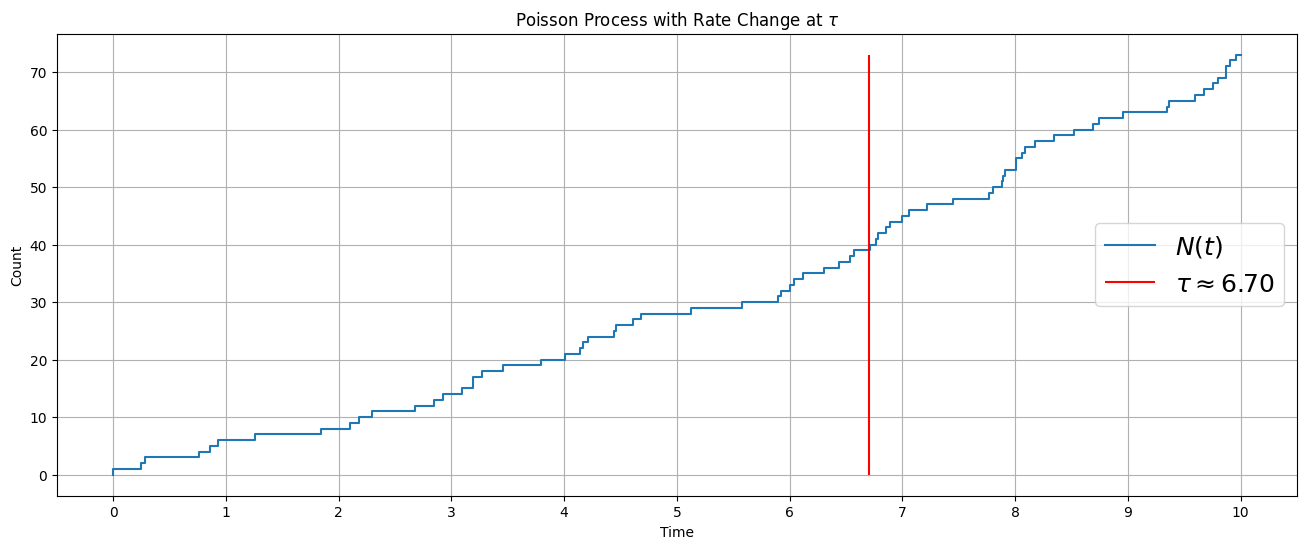

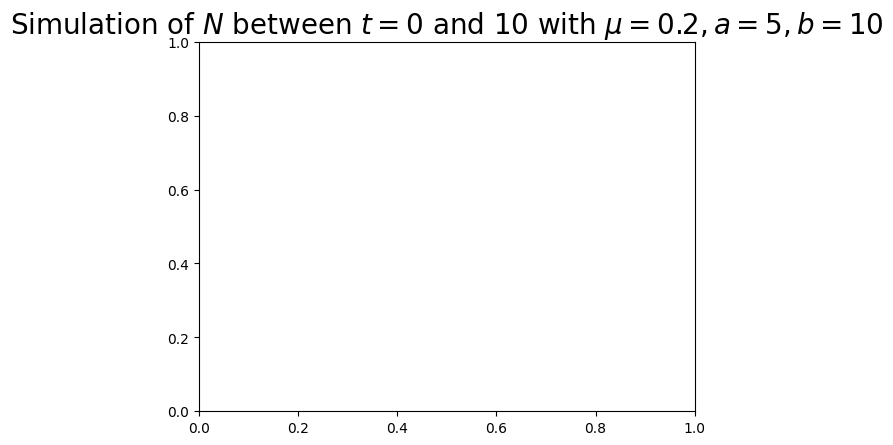

In [5]:
seed = 2
rng = np.random.default_rng(seed)
a = 5
b = 10

tau, Tas, Tbs = N(a, b, rng=rng)
plotN(tau, Tas, Tbs)
plt.title(rf"Simulation of $N$ between $t = 0$ and {10} with $\mu = {0.2}, a = {a}, b = {b}$", fontsize = 20)
plt.show()

Ensuite pour calculer $Z$, on réutilise les calculs de la question 10 pour pouvoir approximer la résolution de son équation différentielle.


$
\dot{y} = (h(t)-(b-a)(y(t))(1-y(t))
$

$
y(T_{n-1})= \hat{Z}(T_{n-1})
$


Et en suite pour les instants de saut donc de discontinuité, on a également l'amplitude donnée par :  

$
 \frac{(b - a) \hat{Z}(T_n) \left(1 - \hat{Z}(T_n^-) \right)}{a - (b - a) \hat{Z}(T_n^-)}
$


In [6]:
import numpy as np
from scipy.integrate import odeint

def Z(a, b, T, mu=0.2, end=10, num=50):
    """
    Computes an approximation of the conditional expectation Z(t) for
    all t between 0 and T

    Parameters
    ----------
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    T : list
        The arrival times of N
    mu : float, optional
        The parameter of the exponential distribution of tau
    end : float, optional
        The end of the simulation
    num : int, optional
        The number of points used to approximate Z between any two arrival times
        (default is 50)

    Returns
    -------
    list
        The list of points used to plot Z (linspaces + arrival times)
    numpy array
        1D array of values of Z
    """

    # Define the derivative of Z
    def dZ(y, t):
        return (mu - (b - a) * y) * (1 - y)

    z = [0]  # Initial condition
    ts = []  # List to store time points
    for i in range(len(T) - 1):
        # Generate points between two arrival times
        t = np.linspace(T[i], T[i + 1], num=num)[:-1]
        ts.extend(t)
        # Solve the differential equation between two points
        z_segment = odeint(dZ, z[-1], t).flatten()
        z.extend(z_segment)
        # Calculate the jump
        z_jump = (b - a) * z_segment[-1] * (1 - z_segment[-1]) / (a + (b - a) * z_segment[-1])
        # Add the jump
        z.append(z_jump + z_segment[-1])
        ts.append(T[i + 1])

    return ts, np.array(z[1:])


In [9]:
import matplotlib.pyplot as plt

def plotZ(ts, z, tau, end=10):
    """
    Plots the graph of the process Z

    Parameters
    ----------
    ts : list
        List of time points
    z : numpy array
        Array of values of Z
    tau : float
        The value of tau
    end : float, optional
        The end of the simulation
    """

    plt.figure(figsize=(16, 6))
    plt.plot(ts, z, label=r'$\hat{Z}(t) = \mathbb{E}\left[\mathbb{1}_{\tau \leq t}|\mathcal{F}^N_t\right]$')
    plt.xticks(range(end + 1))

    if tau <= end:
        plt.vlines(tau, 0, 1, color='r', label=rf'$\tau \approx {tau:.2f}$')
    else:
        plt.vlines(0, 0, 0, color='r', label=rf'$\tau \approx {tau:.2f}$')

    plt.legend(fontsize=15)
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Expectation of Indicator')
    plt.title('Graph of the Process Z')
    plt.show()


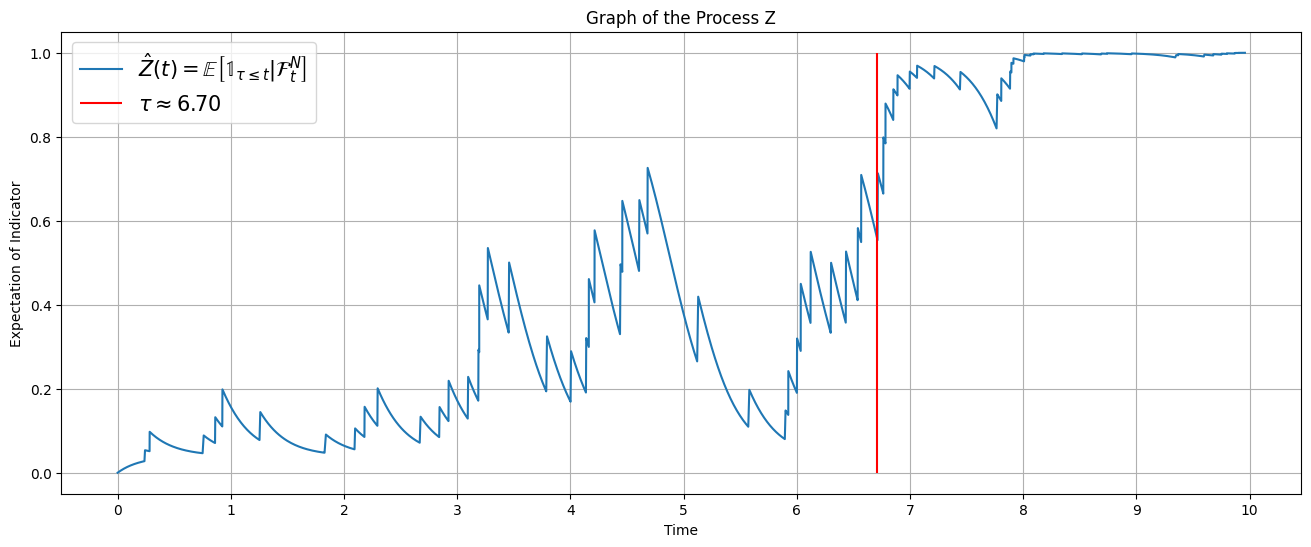

ValueError: 
\hatZ (t)
^
ParseFatalException: Expected token, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 1 Axes>

In [10]:
T = [0] + Tas + Tbs
ts, z = Z(a, b, T)

plotZ(ts, z, tau)
plt.title(rf"Approximation of $\hatZ (t)$ between $t = 0$ and {10} with $\mu = {0.2}, a = {a}, b = {b}$", fontsize = 20)
plt.show()


La courbe semble intuitive, avant $\tau$ on observe des pics désordonnés liés au caractère aléatoire des tirages. Puis une fois que l'on a dépassé $\tau$ la courbe se régularise pour atteindre 1.

# Question 3

Estimation de $\tau$ :

Pour approximer $\tau$ on peut procéder de la façon suivante :    

Il faut d'abord lisser la courbe de Z pour ignorer les sauts ainsi que les erreurs qui peuvent être commises du fait du caractère aléatoire des données (par malchance, on peut avoir beaucoup de sauts rapprochés avant $\tau$ , ce qui conduirait à une augmentation abrupte de Z).

L'objecif est de se rapprocher de l'allure d'une sigmoïde ou d'une indicatrice.

Ensuite, il faut choisir l'abscisse qui approximera le mieux $\tau$

Nous proposons deux idées :

   -fixer un seuil déterminé expérimentalement et mesurer le premier dépassement de ce seuil par la courbe lissée.

   -ou dériver la courbe lissée et choisir l'abscisse du maximum.
    

Ce sont selon nous les critères permettant d'approximer le mieux $\tau$.




# Question 4

Pour cette question, nous allons utiliser l'algorithme de clustering kmeans. On sépare les instants de saut en deux clusters, puis on estime tau en effectuant la moyenne des deux instants à l'extremité des clusters.

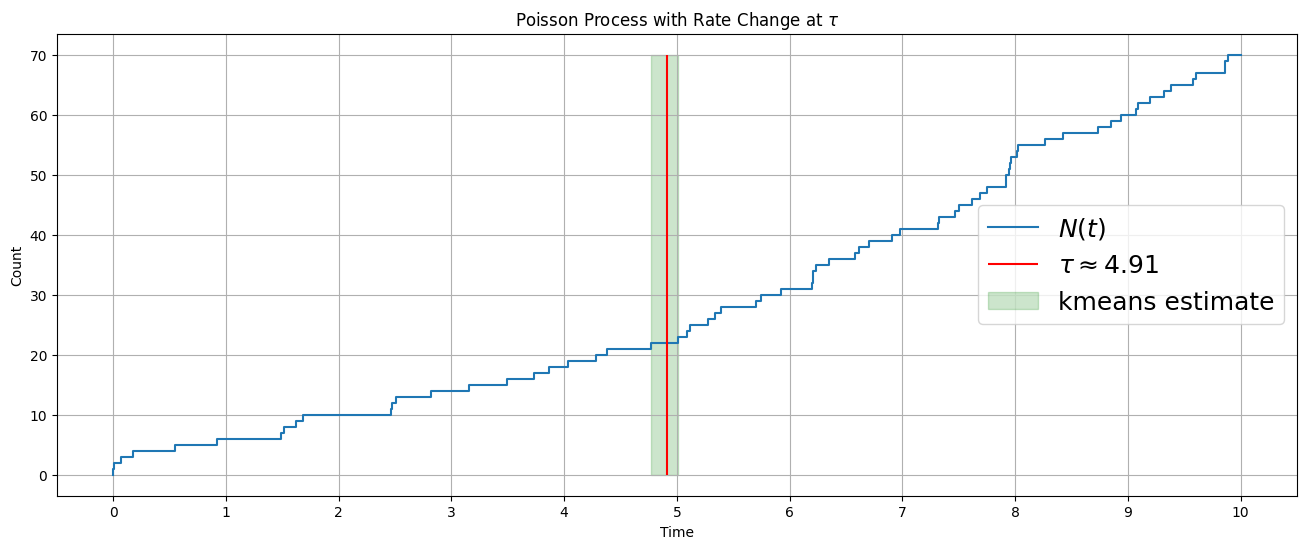

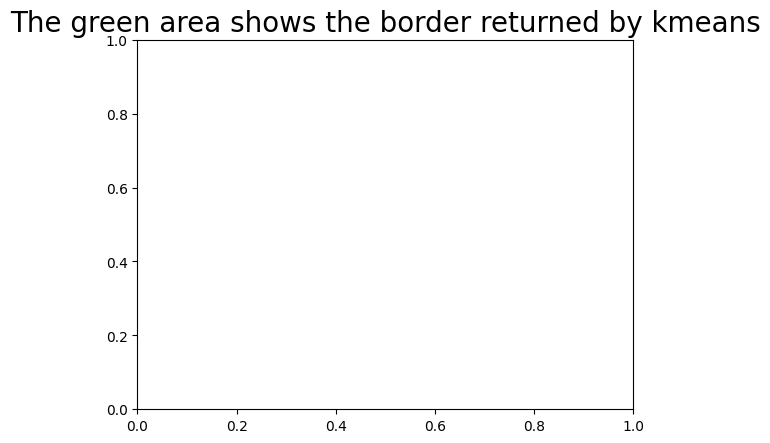

In [12]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

# Generate N again with a RandomState generator this time (required for kmeans implementation in scipy)
tau, Tas, Tbs = N(a, b, rng=rng)
T = [0] + Tas + Tbs

points = np.array(T).reshape(-1, 1)
kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
pred = kmeans.predict(points)
p = abs((1 - pred[0]) - pred)  # make sure 1's are before 0's

plotN(tau, Tas, Tbs, kmeans_estimate=(T[p.sum() - 1], T[p.sum()]))
plt.title("The green area shows the border returned by kmeans", fontsize=20)
plt.show()


Il semble que la méthode soit assez efficace, nous allons faire un calcul d'erreur sur plusieurs itérations pour avoir une idée de la précision de la méthode.

In [13]:
def evaluate_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    """Returns an estimation of the error of the approximation using naive kmeans"""

    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        points = np.array(T).reshape(-1, 1)
        kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [14]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_kmeans(100, a, b, rng = rng)

2.8733964466881816

Le résultat est décevant, l'erreur étant assez importante.
Pour tenter d'améliorer le résultat, on va augementer le nombre de dimensions de nos points en ajoutant :    
- D'une part les points N(t)/t qui tendent vers l'intensité du processus N quand t devient grand
-D'autre part l'inverse de l'intensité en calculant la moyenne des temps d'inter-arrivées.

In [15]:
rate_approx = []
for i in range(1, len(T)) :
    rate_approx.append(i/T[i])
rate_approx = np.array(rate_approx)
rate_approx

array([98.92825983, 27.58432609, 17.13133112,  7.31697905,  5.44507749,
        4.03378992,  4.61690164,  4.94449154,  5.33490186,  4.05902258,
        4.45387817,  4.78767477,  4.61590347,  4.43417938,  4.28999885,
        4.28438615,  4.40020671,  4.46500967,  4.44124962,  4.57004146,
        4.40226207,  4.39060835,  4.51936898,  4.69355872,  4.73978771,
        4.86799729,  5.00615544,  4.91202451,  5.04336405,  5.06156716,
        4.99977781,  5.15669734,  5.31484885,  5.45721018,  5.51253963,
        5.46964946,  5.58936003,  5.67013227,  5.64225843,  5.72868123,
        5.60154205,  5.7307225 ,  5.76091156,  5.86254987,  5.90409042,
        5.98396241,  6.06639656,  6.06334962,  6.18725532,  6.29328428,
        6.41411162,  6.53075128,  6.61362154,  6.73157374,  6.65506503,
        6.64502693,  6.52400811,  6.55422646,  6.59678374,  6.61216241,
        6.70847738,  6.74202986,  6.7574765 ,  6.82002671,  6.78491148,
        6.87348148,  6.79392704,  6.89440613,  6.97751045])

l'approximation semble asssez bonne.

In [16]:
interarrival_approx = []
parsum = 0
for i in range(1, len(T)) :
    parsum += T[i] - T[i - 1]
    interarrival_approx.append(parsum/i)
interarrival_approx = np.array(interarrival_approx)
interarrival_approx

array([0.01010834, 0.03625247, 0.05837258, 0.13666842, 0.18365212,
       0.24790582, 0.21659547, 0.20224526, 0.18744487, 0.24636473,
       0.22452343, 0.20886966, 0.21664231, 0.22552087, 0.2331003 ,
       0.23340567, 0.22726205, 0.22396368, 0.22516185, 0.2188164 ,
       0.22715595, 0.22775887, 0.22126983, 0.21305795, 0.21097991,
       0.20542329, 0.19975408, 0.20358205, 0.19828035, 0.19756727,
       0.20000889, 0.19392257, 0.18815211, 0.18324381, 0.18140459,
       0.18282707, 0.17891136, 0.17636273, 0.17723399, 0.17456025,
       0.17852227, 0.17449807, 0.17358364, 0.17057424, 0.1693741 ,
       0.16711335, 0.1648425 , 0.16492534, 0.16162255, 0.15889954,
       0.15590624, 0.15312174, 0.15120309, 0.14855367, 0.15026149,
       0.15048848, 0.15328001, 0.15257331, 0.15158902, 0.15123645,
       0.14906512, 0.14832328, 0.14798424, 0.14662699, 0.14738586,
       0.14548668, 0.14719028, 0.14504513, 0.14331759])

Ici aussi l'approximation semble cohérente, on tend assez vite vers 0,2 puis on baisse après dépassement de \$tau$.
On va pouvoir faire une représenation 3D

In [17]:
def points_3D(T) :
    """Returns a numpy array of points in 3D to be classified by kmeans"""

    rate_approx = []
    interarrival_approx = []
    parsum = 0
    for i in range(1, len(T)) :
        parsum += T[i] - T[i - 1]
        interarrival_approx.append(parsum/i)
        rate_approx.append(i/T[i])
    T = np.array(T[1:])
    interarrival_approx = np.array(interarrival_approx)
    rate_approx = np.array(interarrival_approx)
    return np.column_stack((T, interarrival_approx, rate_approx))

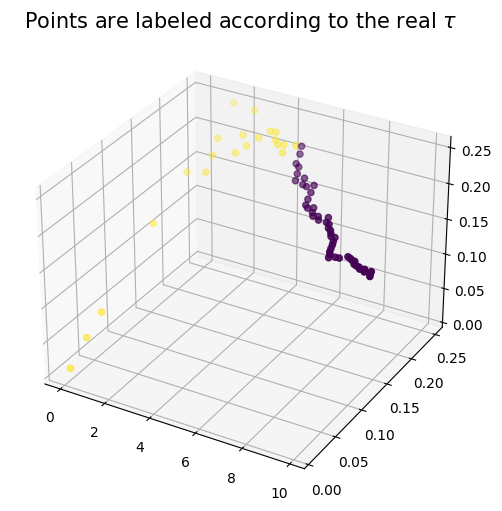

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# Computing the real labels of the points
labels = []
for i in range(1, len(T)) :
    if T[i] < tau :
        labels.append(1)
    else :
        labels.append(0)

points = points_3D(T)
ax.scatter(points.T[0], points.T[1], points.T[2], c=labels)
plt.title(rf"Points are labeled according to the real $\tau$", fontsize = 15)
plt.show()


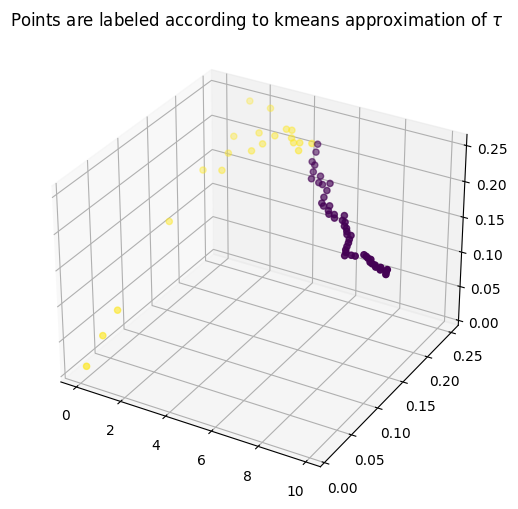

In [19]:
seed = 42
rng = np.random.RandomState(seed)

kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state = rng).fit(points)
pred = kmeans.predict(points)
p = abs((1-pred[0])-pred)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(points.T[0], points.T[1], points.T[2], c=p)
plt.title(rf"Points are labeled according to kmeans approximation of $\tau$", fontsize = 12)
plt.show()

On va maintenant évaluer la classification qui semble plutôt bonne sur la représentation 3D.

In [20]:
def evaluate_3D_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    """Returns an estimation of the error of the approximation using 3D-kmeans"""

    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        points = points_3D(T)
        kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [21]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_3D_kmeans(1000, a, b, rng = rng)

2.768916272423207

Le résultat est à nouveau décevant, nous n'avons plus d'autres idées pour améliorer l'erreur. Le bilan que nous pouvons établir pour le moment est que la méthode de custering est assez limité.